In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/KP/Google/Python/QD")
from sub import parameter, matrix, geometry
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import eigs, spsolve
#import Band_diagram

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

Density of states is defined as gaussian. 
But any other function should be okay, i.e Lorentzian

# Applied Voltage

In [13]:
V = 1 # to align Fermi level, V = 1 is applied
      # when 2V is applied, V is -1
dE = 0.1 # energy spacing
dz = 2e-10  # geometry spacing
y = np.arange(-10, 5, dE) # Energy

dimension = 100e-9 # total 100 nm
z = np.arange(0, dimension, dz)
nz = len(z)


# Define Constant

In [14]:
EH1 = -7.3 # geo1 is ZnO
EH2 = -6.5 # geo2 is QD
EH3 = -6.0 # geo3 is CBP
EL1 = -4.2 # EH is HOMO level
EL2 = -4.0 # EL is LUMO level
EL3 = -2.9
EF  = -4.3 # Fermi level is prone to align with ITO

n = 1e17/1.42e-9*dz  # should be adjustable
eo = 8.85e-12
er = 3.6
kT = 0.0259
q = 1.6e-19
c_array = np.ones(len(z))*er #* eo*er

# Fermi Level

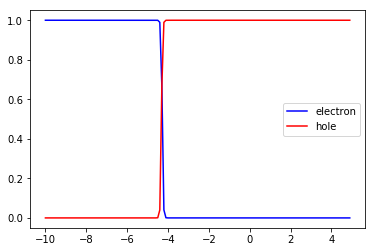

In [15]:
fH = 1/(1/2*np.exp(-(y-EF)/kT)+1)
fL = 1/(1/2*np.exp((y-EF)/kT)+1)
plt.plot(y, fL, 'b', label = 'electron')
plt.plot(y, fH, 'r', label = 'hole')
plt.legend()

# Define Geometry

201 301 501


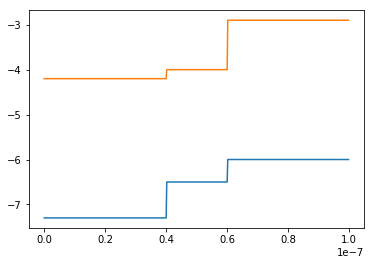

In [16]:
geo = np.zeros(len(z))
EH = np.zeros(len(z))
EL = np.zeros(len(z))
    
geo1 = 40e-9 / dz
geo2 = geo1 + 20e-9 / dz 
geo3 = geo2 + 40e-9 / dz
geo1 = np.int(geo1) + 1
geo2 = np.int(geo2) + 1
geo3 = np.int(geo3) + 1
print geo1, geo2, geo3

for i in range(geo1):
    EH[i] = EH1
    EL[i] = EL1
for i in range(geo1,geo2):
    EH[i] = EH2
    EL[i] = EL2
for i in range(geo2, geo3-1):
    EH[i] = EH3
    EL[i] = EL3
plt.plot(z, EH) # HOMO
plt.plot(z, EL) # LUMO

# Density of States

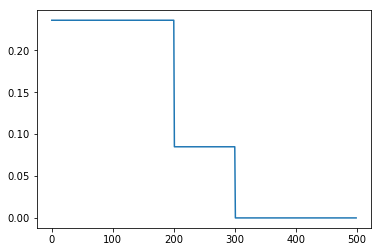

In [17]:
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for i in range(geo1):
    dosH[:,i] = gaussian(y, EH1, 0.25)   
    dosL[:,i] = gaussian(y, EL1, 0.25)   
    ne[:,i] = dosL[:,i]*fL  # [/E /dz]
    nh[:,i] = dosH[:,i]*fH
for i in range(geo1,geo2):
    dosH[:,i] = gaussian(y, EH2, 0.25)   
    dosL[:,i] = gaussian(y, EL2, 0.25)  
    ne[:,i] = dosL[:,i]*fL  # [/E /dz]
    nh[:,i] = dosH[:,i]*fH
for i in range(geo2,geo3-1):
    dosH[:,i] = gaussian(y, EH3, 0.25)   
    dosL[:,i] = gaussian(y, EL3, 0.25)  
    ne[:,i] = dosL[:,i]*fL  # [/E /dz]
    nh[:,i] = dosH[:,i]*fH
neSum = np.sum(ne, axis = 0)*dE  # [/dz]
nhSum = np.sum(nh, axis = 0)*dE 
qden_old = q*n*(nhSum - neSum) # [C/m2/dz]  

plt.plot(neSum) # total charge density

# Define Inhomogeneous Poisson Matrix

Dirichlet : When start z= 0, and end z = zend's V is determined <br\>
Neumann : When start and end's derivative is 0 <br\>
**See my ppt note**

In [18]:
z_boundary = 0 #Dirichlet : 0    Neumann : 1

if z_boundary == 0:
    poisson = diags(-np.append(c_array[1:], c_array[-1]) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
    #poisson[-1,-1] = poisson[-1,-1] + V*c_array[-1]
    
elif z_boundary == 1:
    poisson = diags(-np.append(c_array[1:], c_array[-1]) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
    poisson[-1,-2] *= 2
    #poisson[-1,-1] = 2*c_array[-1] 
    #poisson[-1,-2] = -c_array[-1] *2
poisson /= (dz)
poisson = csr_matrix(poisson)
#p = poisson.todense()

# Initial guess

-0.597379005718 -1.19352756072


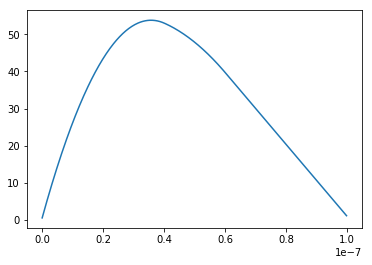

In [19]:
#qden_old /= 1000
#Vz = np.linalg.solve(poisson, -qden_old/eo)
#Vz = spsolve(poisson, -qden_old/eo)
#fig, ax1 = plt.subplots(1,2)

if z_boundary == 0:
        qden_boundary = qden_old + 0
        qden_boundary[-1] = qden_old[-1] - (V*c_array[-1] /dz  * eo)
#        qden_old[-1] -= (V*c_array[-1] / dz * eo)
        Vz = spsolve(poisson, -qden_boundary/eo)
else:
    Vz = spsolve(poisson, -qden_old/eo)
        
plt.plot(z, -Vz)
#plt.ylim([-1.1,0])
print Vz[0], Vz[-1]

# Iteration

In [20]:
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for k in range(50000):
#    Vz = spsolve(poisson, -qden_old/eo)
    
    if z_boundary == 0:
        qden_boundary = qden_old + 0
        qden_boundary[-1] = qden_old[-1] - (V*c_array[-1] / dz * eo)
#        qden_old[-1] -= (V*c_array[-1] / dz * eo)
        Vz = spsolve(poisson, -qden_boundary/eo)
    else:
        Vz = spsolve(poisson, -qden_old/eo)
    
    for i in range(geo1):
        dosH[:,i] = gaussian(y, EH1-Vz[i], 0.25)   
        dosL[:,i] = gaussian(y, EL1-Vz[i], 0.25)   
        ne[:,i] = dosL[:,i]*fL  # [/E /dz]
        nh[:,i] = dosH[:,i]*fH
    for i in range(geo1,geo2):
        dosH[:,i] = gaussian(y, EH2-Vz[i], 0.25)   
        dosL[:,i] = gaussian(y, EL2-Vz[i], 0.25)   
        ne[:,i] = dosL[:,i]*fL  # [/E /dz]
        nh[:,i] = dosH[:,i]*fH
    for i in range(geo2,geo3-1):
        dosH[:,i] = gaussian(y, EH3-Vz[i], 0.25)   
        dosL[:,i] = gaussian(y, EL3-Vz[i], 0.25)   
        ne[:,i] = dosL[:,i]*fL  # [/E /dz]
        nh[:,i] = dosH[:,i]*fH
    neSum = np.sum(ne, axis = 0)*dE  # [/dz]
    nhSum = np.sum(nh, axis = 0)*dE 
    qden_new = q*n*(nhSum - neSum) # [C/m2/dz]    
   
    diff = np.sum(qden_old - qden_new)
    qden_old = (qden_old*999/1000 + qden_new/1000)  # to converge the iteration
    if k % 1000 == 0:
        print k, diff
    #qden_new *= 1000
    #plt.plot(z, -Vz)
#    plt.plot(y, dosL, 'r',  label = 'DOS_E')
    #plt.plot(y, dosL, 'g', label = 'DOS_H')
    if np.abs(diff) < 1e-6:
        break

0 -0.217230552299
1000 0.0134056635327
2000 0.00256015953445
3000 0.000857998982437
4000 0.000263730562848
5000 6.54566412437e-05
6000 1.62409028042e-05
7000 4.44332048081e-06
8000 1.34612841528e-06


V = 1 (when Fermi level is flat / actually no voltage is applied)

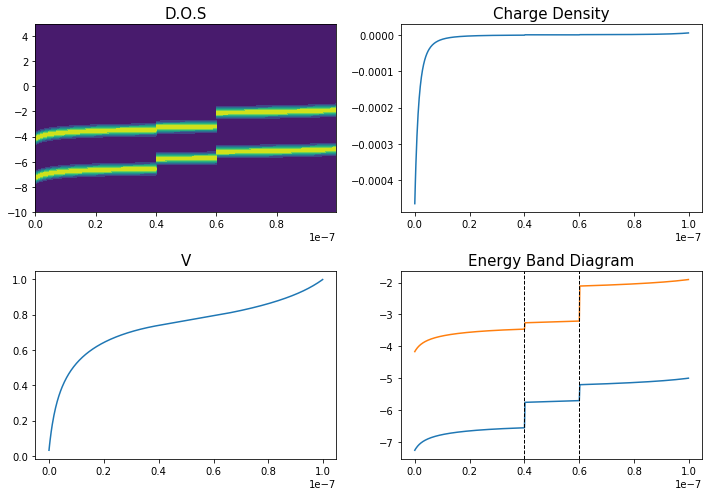

In [21]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].contourf(z,y,dosL+dosH)
ax[0,1].plot(z, qden_old)
ax[1,0].plot(z, -Vz)
ax[1,1].plot(z, EH - Vz)
ax[1,1].plot(z, EL - Vz)
ax[1,1].axvline(0.4e-7, color = 'k', linestyle = '--', linewidth = 1)
ax[1,1].axvline(0.6e-7, color = 'k', linestyle = '--', linewidth = 1)
ax[0,0].set_title('D.O.S', fontsize = 15)
ax[0,1].set_title('Charge Density', fontsize = 15)
ax[1,0].set_title('V', fontsize = 15)
ax[1,1].set_title('Energy Band Diagram', fontsize = 15)
plt.tight_layout()

V = -1 (when 2V is applied)

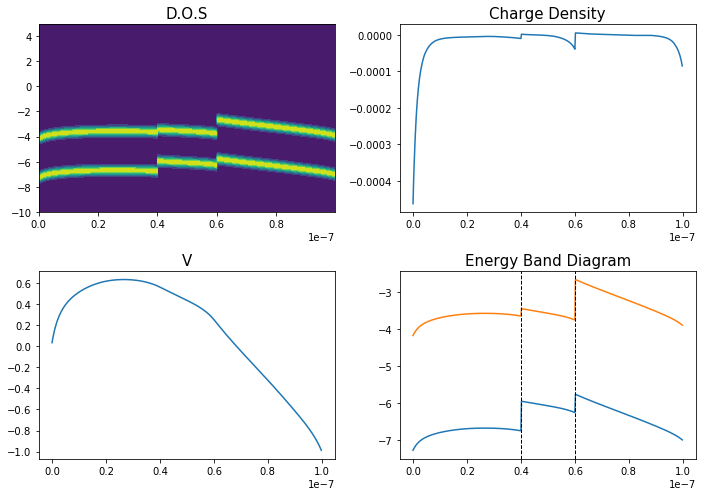

In [73]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].contourf(z,y,dosL+dosH)
ax[0,1].plot(z, qden_old)
ax[1,0].plot(z, -Vz)
ax[1,1].plot(z, EH - Vz)
ax[1,1].plot(z, EL - Vz)
ax[1,1].axvline(0.4e-7, color = 'k', linestyle = '--', linewidth = 1)
ax[1,1].axvline(0.6e-7, color = 'k', linestyle = '--', linewidth = 1)
ax[0,0].set_title('D.O.S', fontsize = 15)
ax[0,1].set_title('Charge Density', fontsize = 15)
ax[1,0].set_title('V', fontsize = 15)
ax[1,1].set_title('Energy Band Diagram', fontsize = 15)
plt.tight_layout()

In [77]:
print (Vz[geo1] - Vz[geo2])/20e-9/1e5, 'kV/cm'

-156.124804521 kV/cm
